In [40]:
# Load libraries
import os
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Lambda, Activation, Flatten, Dropout
from keras.layers import Cropping2D, Conv2D, MaxPooling2D

## Load Data Set

In [41]:
data_path = './data'
data_folders = glob.glob(os.path.join(data_path, '*'))
samples_sim = []
for folder in range(len(data_folders)):
    with open(data_folders[folder]+'/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples_sim.append(line)

print("Done Loading Data") 

Done Loading Data


In [42]:
images = []
measurements = []
for sample_data in samples_sim:    
    source_path = sample_data # Store the center image only [1] is left, [2] is right
    filename = (source_path[0]).split('/')[-1]
    img = cv2.imread(source_path[0])[:,:,::-1]
    images.append(img)
    measurement = float(sample_data[3]) # Steering angle, predicted variable
    measurements.append(measurement)
print("Done Merging Data") 

Done Merging Data


In [45]:
# Assigning information to variables for training
X_train = np.array(images)
y_train = np.array(measurements)

# Number of training examples
n_train = len(X_train)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 3798
Image data shape = (160, 320, 3)
Number of classes = 41


## Augmenting Image Collection

(160, 320, 3)


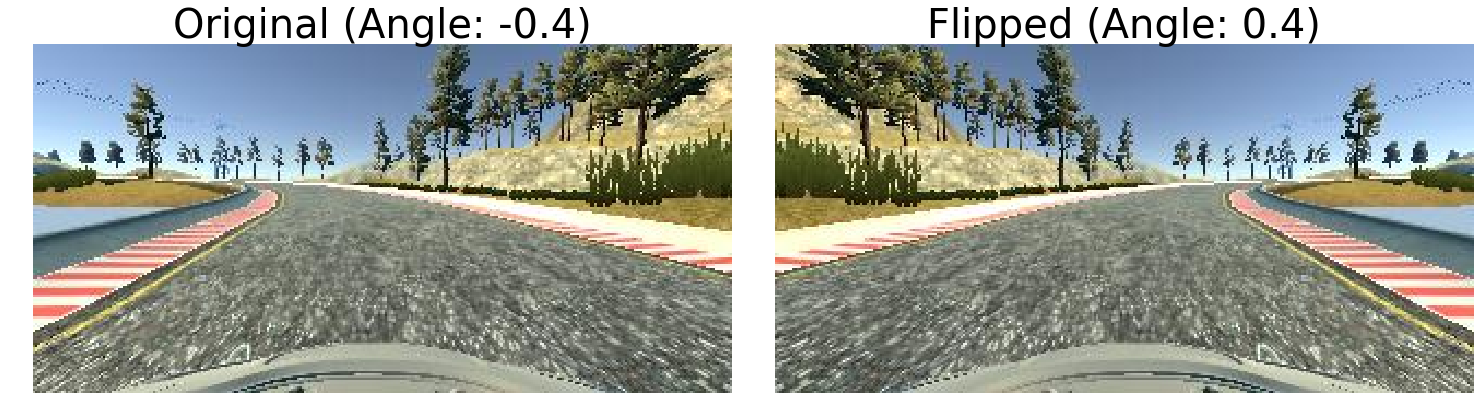

In [46]:
collection_images = []
collection_measurements = []
for image, measurement in zip(images, measurements):
    collection_images.append(image)
    collection_measurements.append(measurement)
    collection_images.append(cv2.flip(image,1))
    collection_measurements.append(measurement*-1.0)
    
X_train = np.array(collection_images)
y_train = np.array(collection_measurements)
print(X_train[0].shape)


# Visualise one image from dataset and its flipped version
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
f.tight_layout()
ax1.imshow(collection_images[1000])
ax1.set_title('Original (Angle: {0})'.format(collection_measurements[1000]), fontsize=40)
ax1.axis('off')

ax2.imshow(collection_images[1001])
ax2.set_title('Flipped (Angle: {0})'.format(collection_measurements[1001]), fontsize=40)
ax2.axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [47]:
# Number of training examples
n_train = len(X_train)

# What's the shape of a simulator image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("NEW Number of training examples =", n_train)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

NEW Number of training examples = 7596
Image data shape = (160, 320, 3)
Number of classes = 41


## Training Model

Normalisation and Zero mean centering,included though a lambda function.

Before training, the last feature was to crop the image 70 pixels from top and 20 pixels from bottom. The reason of this is to avoid the model to "over" learn unnecessary features like the sky, trees and even the car hood.

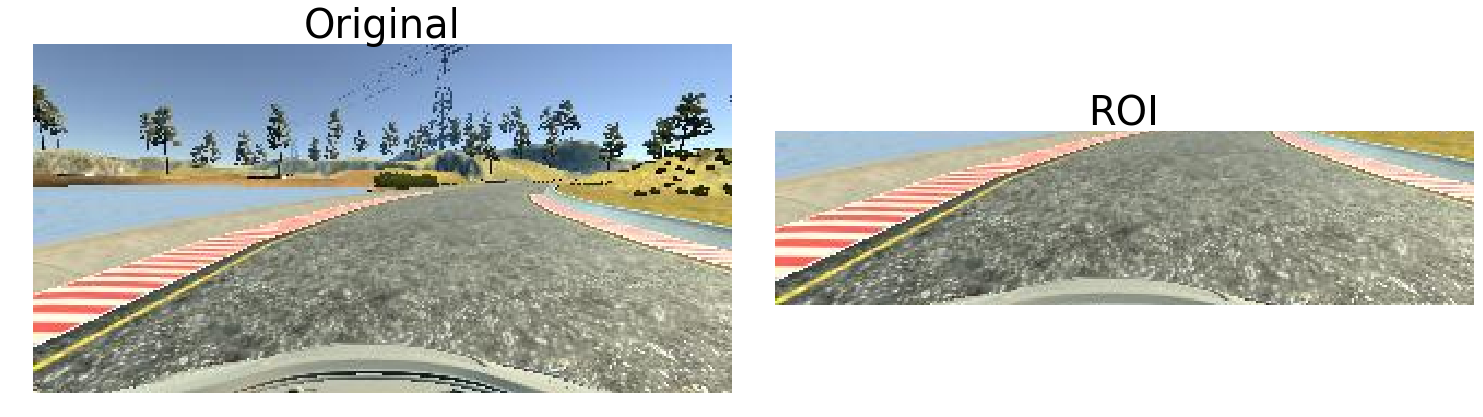

In [67]:
# Visualise one image from dataset, cropping a region of interest (ROI)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
f.tight_layout()
ax1.imshow(images[1000])
ax1.set_title('Original', fontsize=40)
ax1.axis('off')

ax2.imshow(images[1000][70:][:80])
ax2.set_title('ROI', fontsize=40)
ax2.axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [52]:
# TRAINING ...
n_out = 1 # Number of classes to predict. This case: steering angle

# Create the Sequential model
model = Sequential()
print(image_shape)
# Crop images to our ROI. cropping = (y11,y21), (y12,y22)
model.add(Cropping2D(cropping=((70,20), (0,0)), input_shape=image_shape))
print(model.output_shape)
# Pre-process the Data Set. Normalisation and Zero mean centering. 
# The -.5 will shift the mean (0.5) to zero!
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=image_shape))
print(model.output_shape)

#Layer 1
#Conv Layer 1
model.add(Conv2D(filters = 8, kernel_size = 5, strides = 1, 
                 activation = 'relu'))
print(model.output_shape)

#Pooling layer 1
model.add(MaxPooling2D(pool_size = 2, strides = 2))
print(model.output_shape)
#Layer 2
#Conv Layer 2
model.add(Conv2D(filters = 16, kernel_size = 5,strides = 1,
                 activation = 'relu'))
#Pooling Layer 2
model.add(MaxPooling2D(pool_size = 2, strides = 2))
#Flatten
model.add(Flatten())
print(model.output_shape)

#Layer 3
#Fully connected layer 1
model.add(Dense(units = 120, activation = 'relu'))
print(model.output_shape)

'''#Adding a dropout layer to avoid overfitting. Here we are have given the dropout rate as 25% after first fully connected layer
model.add(Dropout(0.25))'''

#Layer 4
#Fully connected layer 2
model.add(Dense(units = 84, activation = 'relu'))
print(model.output_shape)

#Layer 5
#Output Layer , activation = 'softmax'
model.add(Dense(units = n_out))
print(model.output_shape)

#Compile and Fit
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=5)
print('Finished training')

model.save('models/model_LeNet.h5')
print('Model Saved')

(160, 320, 3)
(None, 70, 320, 3)
(None, 70, 320, 3)
(None, 66, 316, 8)
(None, 33, 158, 8)
(None, 17248)
(None, 120)
(None, 84)
(None, 1)


/Users/daniel.reyna/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel_launcher.py:51: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 6076 samples, validate on 1520 samples
Epoch 1/5
6076/6076 [==============================] - 88s 15ms/step - loss: 0.0407 - acc: 0.7299 - val_loss: 0.0183 - val_acc: 0.7816
Epoch 2/5
6076/6076 [==============================] - 92s 15ms/step - loss: 0.0285 - acc: 0.7342 - val_loss: 0.0192 - val_acc: 0.7816
Epoch 3/5
6076/6076 [==============================] - 118s 19ms/step - loss: 0.0225 - acc: 0.7354 - val_loss: 0.0227 - val_acc: 0.7809
Epoch 4/5
6076/6076 [==============================] - 113s 19ms/step - loss: 0.0144 - acc: 0.7383 - val_loss: 0.0237 - val_acc: 0.7789
Epoch 5/5
6076/6076 [==============================] - 91s 15ms/step - loss: 0.0080 - acc: 0.7393 - val_loss: 0.0246 - val_acc: 0.7796
Finished training
Model Saved


In [72]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_5 (Cropping2D)    (None, 70, 320, 3)        0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 70, 320, 3)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 66, 316, 8)        608       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 33, 158, 8)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 154, 16)       3216      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 77, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 17248)             0         
__________

LOG

Using normal regression
- 529 Images. Loss from 12.7503 to 0.1161. Acc 0.4518, NO cropping images
- 1512 Images. Flip and generate new ones, Loss BAD. Classes from 23 to 33!
- 1512 Images. Loss went down, Acc up to 0.4210

Using LeNet
- 1512 Images. Validation Loss from 0.0208 to 0.0128, 76.24% accuracy NICE DRIVE
- Using loss function MSLogarithmicE, cal loss from 0.0088 to ... BAD
- 3547 (model_LeNet_.h5) images, loss from 0.0466 to 0.0440. Good performance on track but stocked at some point!
- ALL 3 Datasets (model_LeNet_3.h5). Very nice performance.

